In [118]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LinearRegression
import scipy.stats as stats

from statsmodels.tsa.stattools import adfuller

from scipy.stats import boxcox
import statsmodels.tsa.api as smt

import matplotlib.pyplot as plt
%matplotlib inline

In [148]:
from pylab import rcParams
rcParams['figure.figsize'] = 12,7

In [120]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv") #Deg
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")  #Close
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")


In [130]:
all_series = {
    "Monthly sales": (sales_of_company_x["Count"]),
    "Monthly robberies": robberies_in_boston["Count"],
    "Monthly airline passengers thds": airlines_passengers["Count"],
    "Mean monthly air temperature ": mean_monthly_temp["Deg"],
    "Weekly closings Dow-Jones": dowjones_closing["Close"],
    "Daily female births": female_births["Count"]
}

In [146]:
def check_DF(series,confidence = .01):
    
    p_value = adfuller(series, autolag='AIC')[1]
    print(f'p_value теста Дики-Фуллера = {p_value :.3f}')
    if p_value > confidence: 
        print(f'критерий Стьюдента > {confidence} \n \t--> H0 = True: корни AR уравнения равны 1 с {(1-confidence) *100:.0f} % уверенностью \n \t это значит Распределение НЕ стационарное') 
    else: 
        print(f'критерий Стьюдента < {confidence} --> H1 = True: корни AR уравнения  НЕ равны 1 с {(1-confidence) *100:.0f} % уверенностью\n это значит Распределение стационарное')

    return p_value

In [147]:
check_DF(sales_of_company_x.Count)

p_value теста Дики-Фуллера = 0.989
критерий Стьюдента > 0.01 
 	--> H0 = True: корни AR уравнения равны 1 с 99 % уверенностью 
 	 это значит Распределение НЕ стационарное


0.9888894205170052

#### Сделаем свой Тест Дики — Фуллера с блекджеком и

In [243]:
def get_ttest(a,confidence=.01,debug=True ):
    # Создаем массив с значениями y ( y[i] ), y предыдущее( y[i-1] ) и y пред. предыдущее( y[i-2] )  
    array_1 = pd.DataFrame({'y':a[:-2], 'y_i_1':a[1:-1], 'y_i_2':a[2:] ,'ones':np.full(len(a) - 2 , 1.) })

    # Обучаем лин регрессию чтобы получить коэффициенты для AR . Строим модель AR(2)  из элементов  y[i] и y[i-2]
    lin_reg = LinearRegression(n_jobs=-1).fit( array_1[['y_i_1','y_i_2','ones' ]],array_1.y )

    # Создаем массив для тестовой выборки
    x = np.random.randint(20,500,size=1001)

    # Берем коэффициенты из линейной регресии и собираем ряд на тестовой выборки  (это ряд для версии H0)
    alpha_1, alpha_2, alpha_0 = lin_reg.coef_
    e = lin_reg.intercept_
    array_H0 =  alpha_0 + x[:-1]*alpha_1+ x[1:]*alpha_2 + e

    # Обучаем лин регрессию чтобы получить коэффициенты для AR . Строим модель AR(1) из элементов y[i-2]
    lin_reg_2 = LinearRegression(n_jobs=-1).fit( array_1[['y_i_2','ones' ]],array_1.y )

    # Берем коэффициенты из линейной регресии и собираем ряд на тестовой выборки  (это ряд для версии H1)
    H1_alpha_1, H1_alpha_0 = lin_reg_2.coef_
    H1_e = lin_reg_2.intercept_
    array_H1 =  H1_alpha_1*x[1:]+  H1_alpha_0 + H1_e

    # роверяем принадлежат ли выборки одной Ген Совокупности. Если принадлежат - то H0 = True и выборка не стационарна для этого лага
    confidence = confidence
    student_criteria = stats.ttest_ind(array_H0,array_H1,equal_var=False)
    
    if debug == False: 
        return student_criteria[1]
    
    print(f'критерий Стьюдента = {student_criteria[1] :.3f}')
    if student_criteria[1] > confidence: 
        print(f'критерий Стьюдента > {confidence} \n \t--> H0 = True: корни AR уравнения равны 1 с {(1-confidence) *100:.0f} % уверенностью \n \t это значит Распределение НЕ стационарное') 
    else: 
        print(f'критерий Стьюдента < {confidence} --> H1 = True: корни AR уравнения  НЕ равны 1 с {(1-confidence) *100:.0f} % уверенностью\n это значит Распределение стационарное')

    return student_criteria[1]

In [115]:
# проверка:
get_ttest(a,debug=False)

критерий Стьюдента = 0.108


0.10777895962539268

In [293]:
def get_DF(series, n_lags=None, print_calculations=True ):
    if n_lags is None:
        nobs = len(series)
        n_lags = int(12*(nobs/100)**.25)
    results = []   

    for lag in range(1,n_lags):
        #print(f' используем шаг в {lag} мес.')
            
        #Собираем массив значений 'y' с шагом 'lag' мес.
        array_with_lag = np.array( [data for i, data in enumerate(series) if i%lag==0] )
        results.append(get_ttest(array_with_lag,debug=False) )
        #print('-'*55)

    max_student = np.array(results).max()
    print(f'Max критерий Стьюдента = {max_student :.3f}')
    
    if print_calculations == False: 
        return max_student
    else:
        if max_student > 0.01: 
            print('корни AR уравнения равны 1 с 99 % уверенностью \n это значит Распределение НЕ стационарное' )
        else: 
            print('корни AR уравнения < 1 с 99 % уверенностью \n это значит Распределение стационарное' )
        return max_student

#### Проверим

In [275]:
series = sales_of_company_x.Count
get_DF(series,print_calculations=False)

Max критерий Стьюдента = 0.999


0.9989838061815812

#### Работает. 

In [320]:
# Функция для быстрого построения графиков:
def get_TS_plots(series,title='Series'):
    fig = plt.figure(figsize=(12,7))
    
    fig.add_subplot(211)
    plt.plot(series)
    plt.title(title)
    plt.grid();
    ax = fig.add_subplot(212)
    smt.graphics.plot_acf(series,ax=ax, alpha=0.05)
    
    plt.grid();

### ДЗ. распределения для стандартизации: 

1. Monthly sales of company X"
1. "Monthly Boston armed robberies"
1. "International airline passengers: monthly totals in thousands"
1. "Mean monthly air temperature (Deg. F) Nottingham Castle"
1. "Weekly closings of the Dow-Jones industrial average"
1. "Daily total female births in California"

#### 1.Monthly sales of company X

Посмотрим на распределение

In [404]:
series = sales_of_company_x.Count

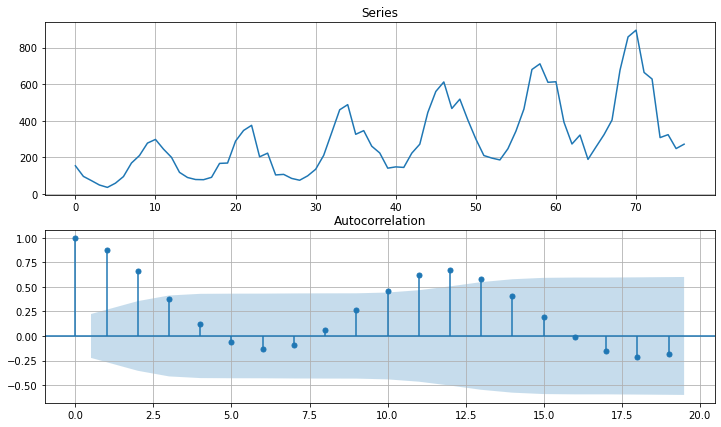

In [405]:
get_TS_plots(series)

График имеет выраженный рост Дисперсии, Цикличность (пероидом 8-12 единиц шкалы х).

План эвакуации: 
- Сначала уберем рост Дисперсии --> BoxCox преобразование
- Потом уберем сезонность и тренд --> дифференцирование.
- Потом проверим на Тесте Дики-Фуллера

In [406]:
series = boxcox(series)[0]

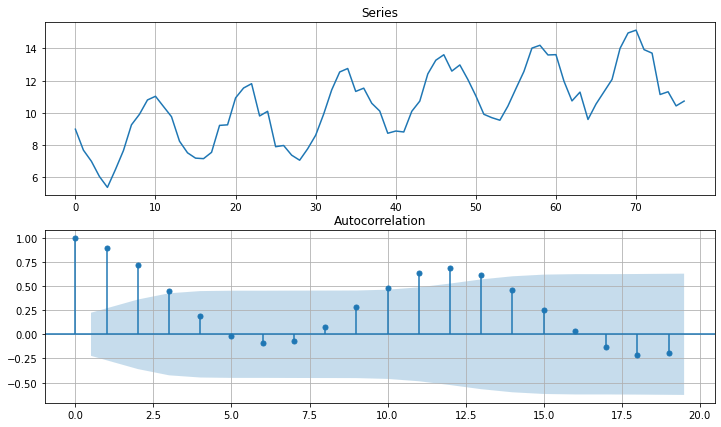

In [407]:
get_TS_plots(series)

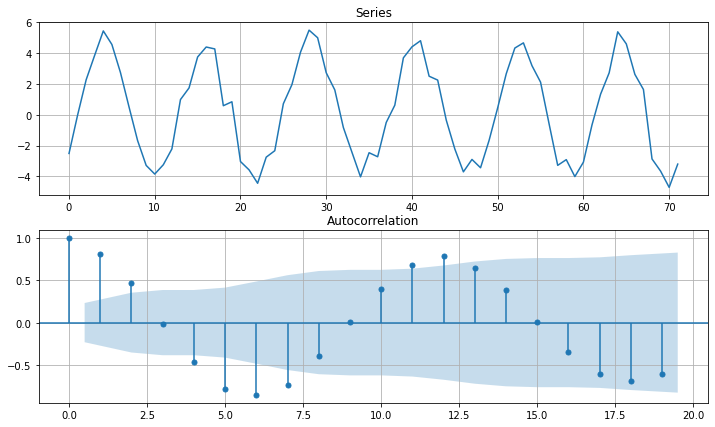

In [408]:
# Дисперсию убрали, теперь уберем тренд
get_TS_plots(series[5:] - series[:-5])
series = series[5:] - series[:-5]

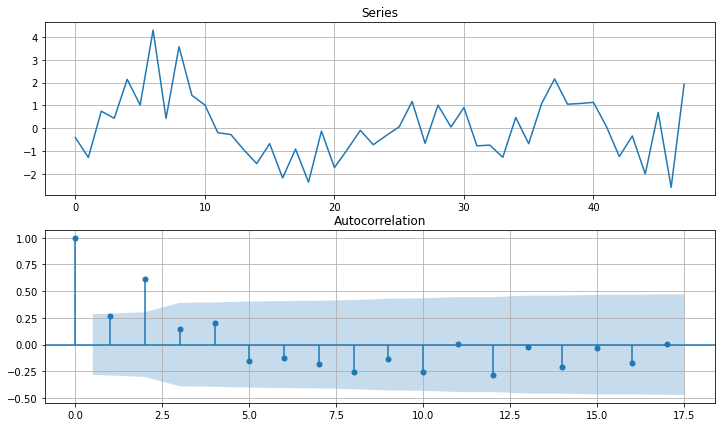

In [409]:
# тренд убрали, теперь уберем Цикличность
series = series[12:] - series[:-12]
get_TS_plots(series[12:] - series[:-12])

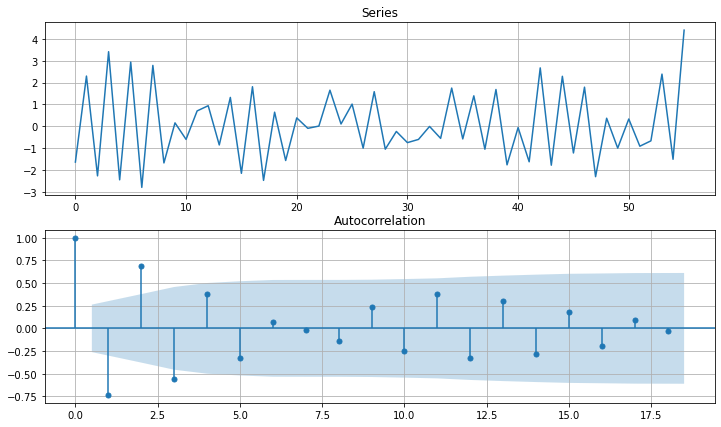

In [415]:
series = series[3:] - series[:-3]
get_TS_plots(series)

In [411]:
# Тест Дики-Фуллера на стационарность ряда:
get_DF(series, print_calculations=True)

Max критерий Стьюдента = 0.000
корни AR уравнения < 1 с 99 % уверенностью 
 это значит Распределение стационарное


5.174963203651466e-05

In [416]:
check_DF(series)

p_value теста Дики-Фуллера = 0.000
критерий Стьюдента < 0.01 --> H1 = True: корни AR уравнения  НЕ равны 1 с 99 % уверенностью
 это значит Распределение стационарное


5.8213649392736036e-08

Тест Дики- Фуллера показывает что распределение стационарное.

#### Отлично! Ряд: 'Monthly sales of company X' мы привели к стационарному виду.

Do you want to continue? [Y/n]   ▋

### 2.Monthly Boston armed robberies

Посмотрим на распределение

In [370]:
series = robberies_in_boston.Count

In [371]:
series = np.array(series)

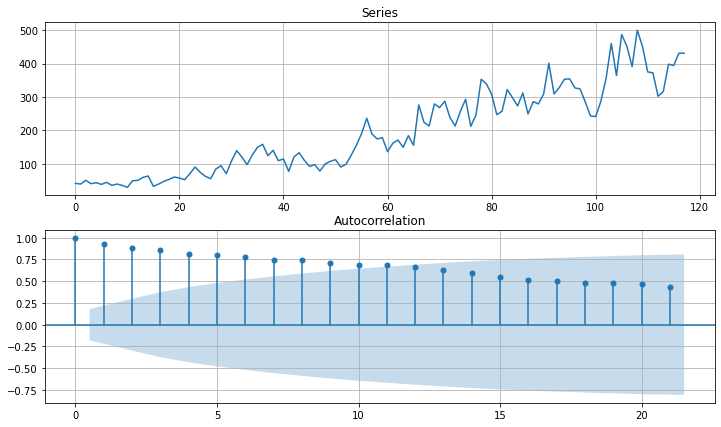

In [372]:
get_TS_plots(series)

График имеет выраженный тренд.

План эвакуации: 
- Сначала уберем тренд --> дифференцирование.
- Потом проверим на Тесте Дики-Фуллера

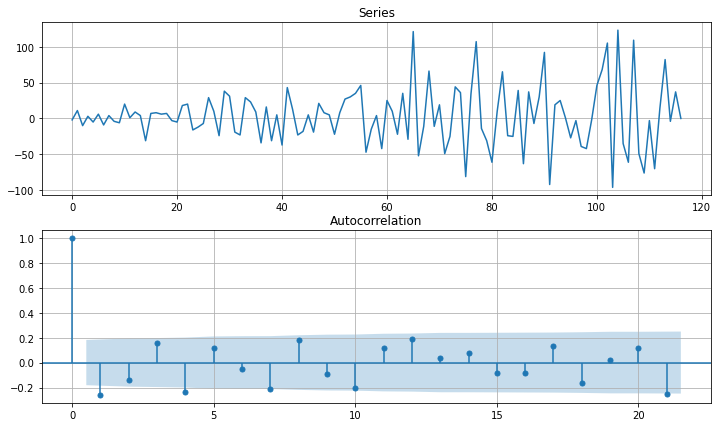

In [373]:
# уберем тренд
get_TS_plots(series[1:] - series[:-1])
series = series[1:] - series[:-1]

In [374]:
# Тест Дики-Фуллера на стационарность ряда:
get_DF(series, print_calculations=True)

Max критерий Стьюдента = 0.000
корни AR уравнения < 1 с 99 % уверенностью 
 это значит Распределение стационарное


3.983073327032186e-10

In [335]:
check_DF(series)

p_value теста Дики-Фуллера = 0.000
критерий Стьюдента < 0.01 --> H1 = True: корни AR уравнения  НЕ равны 1 с 99 % уверенностью
 это значит Распределение стационарное


6.450795412687034e-11

Тест Дики- Фуллера показывает что распределение стационарное.

### 3.Monthly international airline passengers, ths

Посмотрим на распределение

In [361]:
series = airlines_passengers.Count
series = np.array(series)

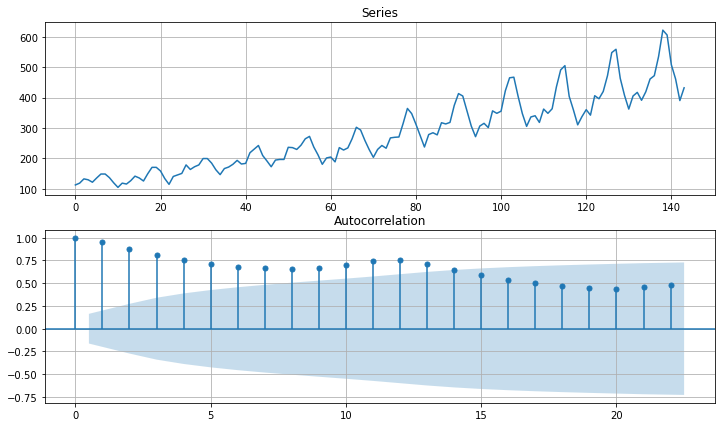

In [362]:
get_TS_plots(series)

График имеет выраженный рост Дисперсии, Цикличность (пероидом 8-12 единиц шкалы х).

План эвакуации: 
- Сначала уберем рост Дисперсии --> BoxCox преобразование
- Потом уберем сезонность и тренд --> дифференцирование.
- Потом проверим на Тесте Дики-Фуллера

In [363]:
series = boxcox(series)[0]

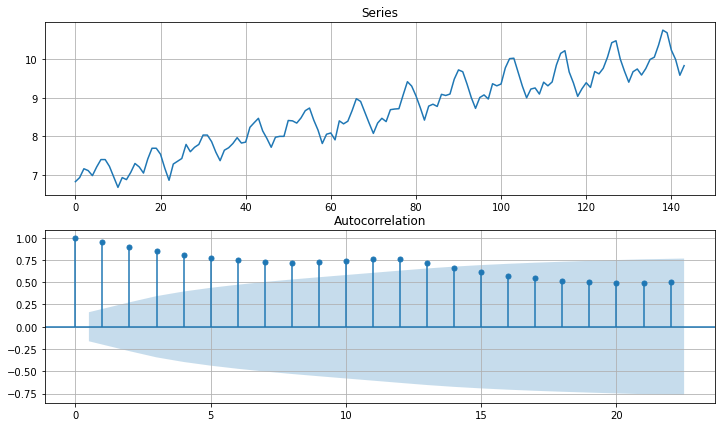

In [364]:
get_TS_plots(series)

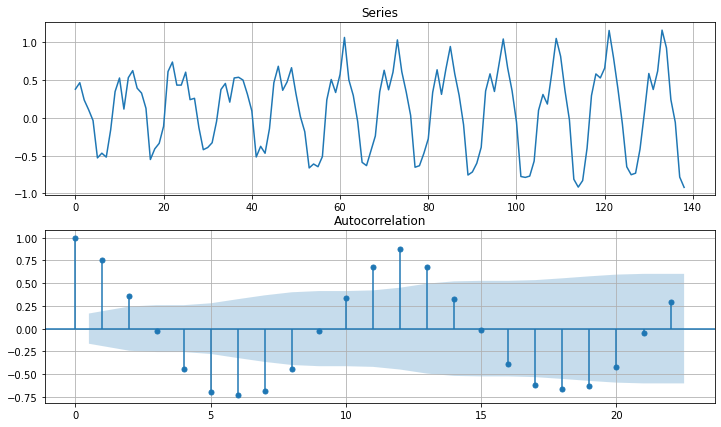

In [365]:
# Дисперсию убрали, теперь уберем тренд
get_TS_plots(series[5:] - series[:-5])
series = series[5:] - series[:-5]

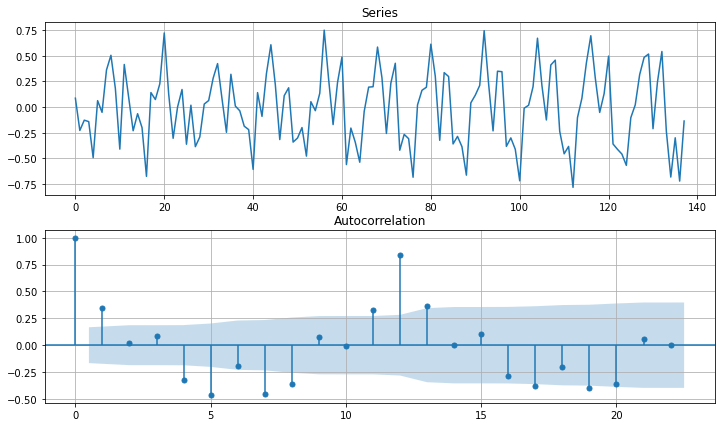

In [366]:
# тренд убрали, теперь уберем Цикличность
series = series[1:] - series[:-1]
get_TS_plots(series)

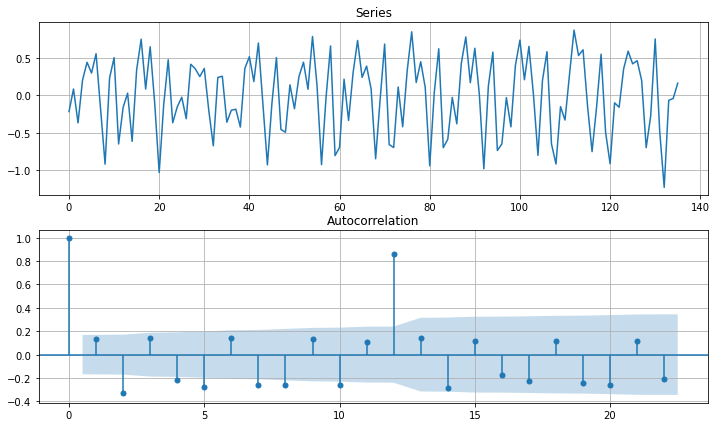

In [367]:
# есть сильная корреляция на 13 лаге, уберем
series = series[2:] - series[:-2]
get_TS_plots(series)

In [375]:
# Тест Дики-Фуллера на стационарность ряда:
get_DF(series, print_calculations=True)

Max критерий Стьюдента = 0.000
корни AR уравнения < 1 с 99 % уверенностью 
 это значит Распределение стационарное


4.333801741183836e-10

In [369]:
check_DF(series)

p_value теста Дики-Фуллера = 0.000
критерий Стьюдента < 0.01 --> H1 = True: корни AR уравнения  НЕ равны 1 с 99 % уверенностью
 это значит Распределение стационарное


2.9529964164959095e-25

Тест Дики- Фуллера показывает что распределение стационарное.

#### Отлично! Ряд: 'Monthly international airline passengers' мы привели к стационарному виду.

Do you want to continue? [Y/n]   ▋

### 4.Mean monthly air temperature city 'X', F

Посмотрим на распределение

In [351]:
series = mean_monthly_temp.Deg
series = np.array(series)

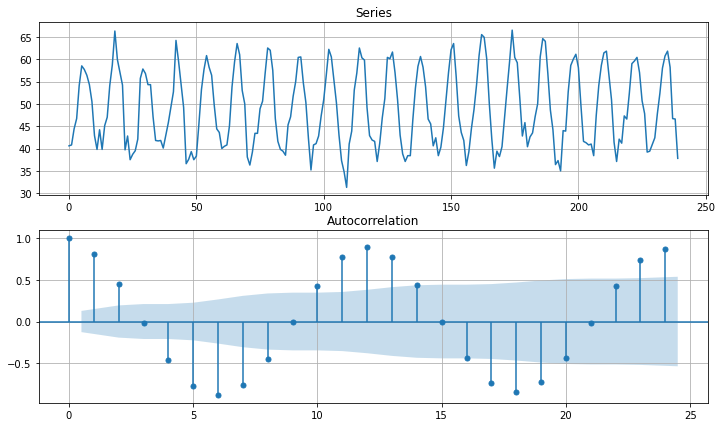

In [352]:
get_TS_plots(series)

График имеет выраженную Сезонность (пероидом 12 мес.).

План эвакуации: 
- Сначала Цикличность --> дифференцирование.
- Потом проверим на Тесте Дики-Фуллера

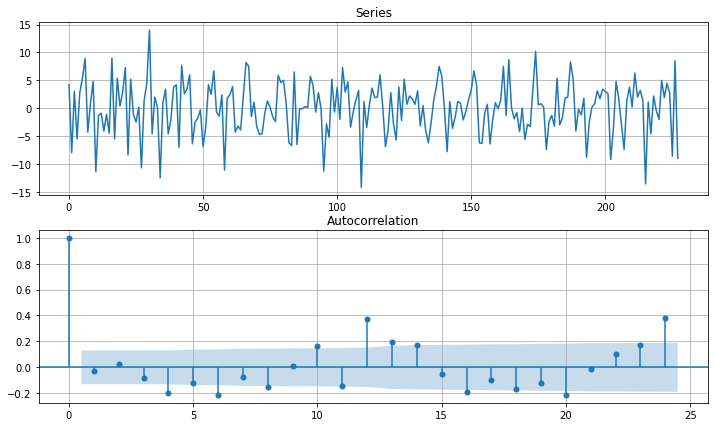

In [357]:
# уберем Цикличность
series = series[11:] - series[:-11]
get_TS_plots(series)


есть сильная корреляция на 12 лаге, не убирается никаким дифференцированием 


In [379]:
# Тест Дики-Фуллера на стационарность ряда:
get_DF(series, print_calculations=True)

Max критерий Стьюдента = 0.000
корни AR уравнения < 1 с 99 % уверенностью 
 это значит Распределение стационарное


1.3248644181890695e-10

In [360]:
check_DF(series)

p_value теста Дики-Фуллера = 0.000
критерий Стьюдента < 0.01 --> H1 = True: корни AR уравнения  НЕ равны 1 с 99 % уверенностью
 это значит Распределение стационарное


4.7353637917879225e-26

Тест Дики- Фуллера показывает что распределение стационарное.

#### Отлично! Ряд: 'Mean monthly air temperature city 'X'' мы привели к стационарному виду.

Do you want to continue? [Y/n]   ▋

### 5.Weekly closings of the Dow-Jones

Посмотрим на распределение

In [386]:
series = dowjones_closing.Close
series = np.array(series)

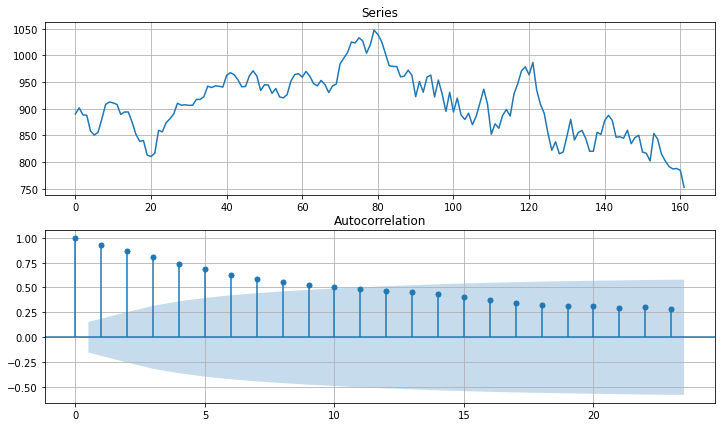

In [381]:
get_TS_plots(series)

График имеет два тренда и периодическую цикличность

План эвакуации: 
- Сначала уберем тренд --> дифференцирование
- Потом уберем цикличность --> дифференцирование.
- Потом проверим на Тесте Дики-Фуллера

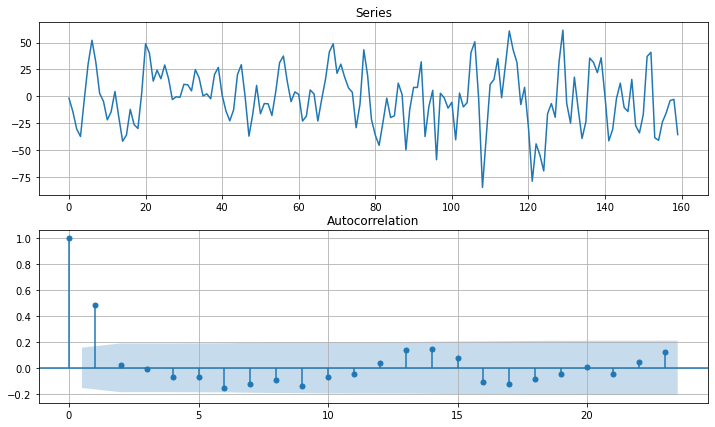

In [388]:
# уберем тренд и цикличность
series = series[2:] - series[:-2]
get_TS_plots(series)

In [389]:
# Тест Дики-Фуллера на стационарность ряда:
get_DF(series, print_calculations=True)

Max критерий Стьюдента = 0.007
корни AR уравнения < 1 с 99 % уверенностью 
 это значит Распределение стационарное


0.0069553496793064605

In [390]:
check_DF(series)

p_value теста Дики-Фуллера = 0.000
критерий Стьюдента < 0.01 --> H1 = True: корни AR уравнения  НЕ равны 1 с 99 % уверенностью
 это значит Распределение стационарное


4.4367882729769635e-05

Тест Дики- Фуллера показывает что распределение стационарное.

#### Отлично! Ряд: 'Weekly closings of the Dow-Jones' мы привели к стационарному виду.

Do you want to continue? [Y/n]   ▋

### 6.Daily total female births in city 'X'

Посмотрим на распределение

In [395]:
series = female_births.Count
series = np.array(series)

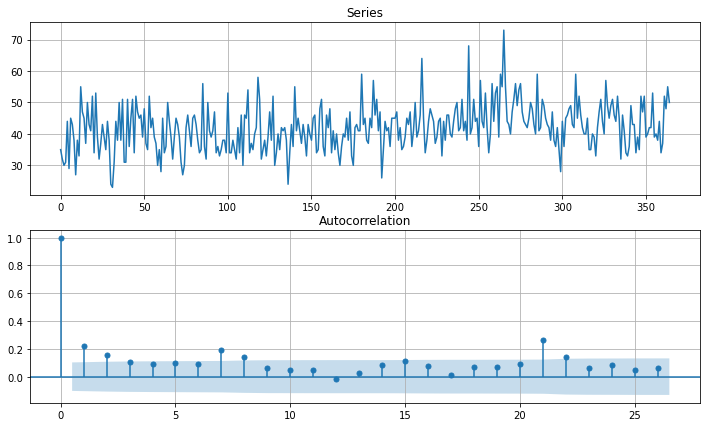

In [392]:
get_TS_plots(series)

График имеет корреляцию на лагах 7-8, не сильно выраженную цикличность

План эвакуации: 
- Сначала цикличность --> дифференцирование.
- Потом проверим на Тесте Дики-Фуллера

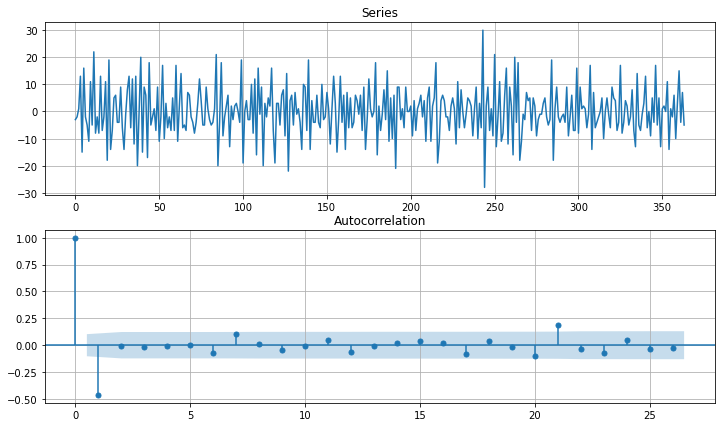

In [400]:
# уберем цикличность
series = series[1:] - series[:-1]
get_TS_plots(series)

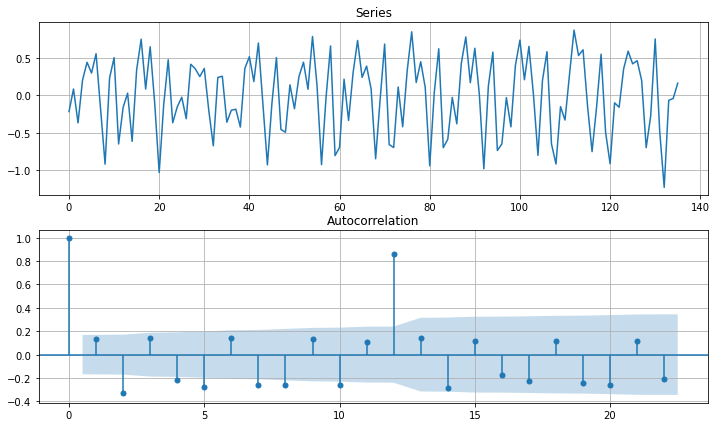

In [367]:
# есть сильная корреляция на 2 лаге, уберем
series = series[2:] - series[:-2]
get_TS_plots(series)

In [413]:
# Тест Дики-Фуллера на стационарность ряда:
get_DF(series, print_calculations=True)

Max критерий Стьюдента = 0.000
корни AR уравнения < 1 с 99 % уверенностью 
 это значит Распределение стационарное


3.650661751620326e-05

In [401]:
check_DF(series)

p_value теста Дики-Фуллера = 0.000
критерий Стьюдента < 0.01 --> H1 = True: корни AR уравнения  НЕ равны 1 с 99 % уверенностью
 это значит Распределение стационарное


1.5472400091968226e-23

Тест Дики- Фуллера показывает что распределение стационарное.

#### Отлично! Ряд: 'Monthly international airline passengers' мы привели к стационарному виду.

Do you want to continue? [Y/n]   ▋

In [ ]:
for i in range(1,15):
    timeseries = series[i:] - series[:-i]
    print(i,adfuller(timeseries, autolag='AIC')[1])
    
    get_TS_plots(timeseries,title=i)
    #plt.show();